# Cancer Dataset Exploration

Insights drawn from the sample dataset


In [27]:
# Ensure project root is on sys.path so 'modules' can be imported when running from 'insight'
import sys, os
from pathlib import Path as _Path
_CWD = _Path.cwd()
_ROOT = _CWD.parent if (_CWD.name == 'insight' and (_CWD.parent / 'modules').exists()) else _CWD
if str(_ROOT) not in sys.path:
    sys.path.insert(0, str(_ROOT))
# 데이터 분석 및 시각화에 필요한 라이브러리들을 가져옵니다.
# pathlib: 파일 경로를 쉽게 다루기 위한 라이브러리
from pathlib import Path
# display: Jupyter Notebook에서 데이터프레임 등을 예쁘게 출력하기 위해 사용
from IPython.display import display

# 기본 호출
import matplotlib.pyplot as plt
import matplotlib.ticker as mstick
import numpy as np
import pandas as pd
import seaborn as sns
import platform

from matplotlib import rcParams

# modules
import modules.DataSelect as DataSelect
import modules.DataAnalysis as DataAnalysis
import modules.ModelAnalysis as ModelAnalysis
import modules.DataModify as DataModify
from modules.DataModify import DataPreprocessing

import modules.Models as Models


# csv 파일 안전하게 읽기 (PC 메모리가 너무 작음)
from modules.smart_csv import process_csv_stream, csv_to_parquet_stream

# seaborn의 기본 테마를 설정합니다. 'whitegrid' 스타일과 'crest' 색상 팔레트를 사용합니다.
sns.set_theme(style="whitegrid", palette="crest")


In [28]:
# 대용량 CSV를 메모리 부담 없이 불러오기 위한 헬퍼를 정의합니다.
import gc
from itertools import chain

# 분석에 필요한 칼럼 중심으로 로딩하여 초기 메모리 사용량을 줄입니다.
RISK_DATA_USECOLS = [
    'Patient ID',
    'Age recode with <1 year olds and 90+',
    'Sex',
    'Year of diagnosis',
    'Year of follow-up recode',
    'Race recode (W, B, AI, API)',
    'Site recode ICD-O-3/WHO 2008',
    'Primary Site',
    'Primary Site - labeled',
    'Derived Summary Grade 2018 (2018+)',
    'Laterality',
    'EOD Schema ID Recode (2010+)',
    'Combined Summary Stage with Expanded Regional Codes (2004+)',
    'RX Summ--Surg Prim Site (1998+)',
    'RX Summ--Scope Reg LN Sur (2003+)',
    'RX Summ--Surg Oth Reg/Dis (2003+)',
    'COD to site recode',
    'Sequence number',
    'Median household income inflation adj to 2023',
    'Number of Cores Positive Recode (2010+)',
    'Number of Cores Examined Recode (2010+)',
    'EOD Primary Tumor Recode (2018+)',
    'PRCDA 2020',
    'Survival months flag',
    'Survival months',
    'Vital status recode (study cutoff used)',
]


def load_risk_dataset(csv_paths, usecols='auto', chunksize=150_000):
    """Stream multiple CSV files with dtype downcasting and categorical compression."""
    resolved_usecols = RISK_DATA_USECOLS if usecols == 'auto' else usecols

    chunk_streams = (
        process_csv_stream(
            csv_path=str(path),
            usecols=resolved_usecols,
            chunksize=chunksize,
        )
        for path in csv_paths
    )

    frames = list(chain.from_iterable(chunk_streams))
    if not frames:
        columns = resolved_usecols if resolved_usecols not in (None, 'auto') else []
        return pd.DataFrame(columns=columns)

    combined = pd.concat(frames, ignore_index=True)
    del frames
    gc.collect()

    if 'Survival months' in combined.columns:
        combined['Survival months'] = pd.to_numeric(combined['Survival months'], errors='coerce')

    return combined


In [29]:
# 범주형 인코딩/디코딩 유틸: modules.DataModify 사용과 동일한 방식으로 통합.
DECODE_MAPS = {}

def build_decode_maps(categories):
    return {
        col: {code: original for original, code in mapping.items()}
        for col, mapping in categories.items()
        if col != 'encoding_type'
    }

def decode_series(frame, column, decode_maps=None):
    maps = decode_maps if decode_maps is not None else DECODE_MAPS
    mapping = maps.get(column)
    if mapping is None:
        return frame[column]
    return frame[column].map(mapping)

def decode_value(column, value, decode_maps=None):
    maps = decode_maps if decode_maps is not None else DECODE_MAPS
    mapping = maps.get(column)
    if mapping is None:
        return value
    return mapping.get(value, value)


In [30]:
import warnings

warnings.filterwarnings('ignore')

In [31]:
# 시각화에서 한글이 깨지지 않도록 나눔고딕 폰트를 설정합니다.
# 시스템에 폰트가 설치되어 있지 않으면 오류가 발생할 수 있어 try-except 구문으로 감쌌습니다.
try:
    plt.rc('font', family='NanumGothic')
except Exception:
    pass
# 마이너스 부호가 깨지는 것을 방지하는 설정입니다.
plt.rc('axes', unicode_minus=False)


### Feature correlation

Heatmap of numeric features after excluding `Patient ID` and encoding `Vital status recode` to inspect its relationship with other predictors.


## DeepSurv risk segmentation (3-month intervals)

`../data/2022Data_short.csv`를 기반으로 DeepSurv 모델 설계를 위한 범주별 위험도 패턴을 살펴봅니다.


In [32]:
# 데이터셋 병합
DATA_PATHS = [
    Path('../data/2022Data_part1.csv'),
    Path('../data/2022Data_part2.csv'),
]
DATA_PATH3 = Path('../data/encoded_dataset.csv')

# 메모리를 과도하게 사용하지 않도록 청크 단위로 데이터를 결합합니다.
risk_df = load_risk_dataset(DATA_PATHS)
encoded_df = pd.read_csv(DATA_PATH3)

memory_mb = risk_df.memory_usage(deep=True).sum() / 1024 ** 2
print(f"Loaded risk dataset: {risk_df.shape[0]:,} rows, {risk_df.shape[1]} columns (~{memory_mb:.1f} MB)")


Loaded risk dataset: 528,403 rows, 26 columns (~193.1 MB)


In [33]:
encoded_df.head()

,Patient ID,Age recode with <1 year olds and 90+,Sex,Year of diagnosis,Year of follow-up recode,"Race recode (W, B, AI, API)",Site recode ICD-O-3/WHO 2008,Primary Site,Primary Site - labeled,Derived Summary Grade 2018 (2018+),...,RX Summ--Surg Oth Reg/Dis (2003+),Sequence number,Median household income inflation adj to 2023,Number of Cores Positive Recode (2010+),Number of Cores Examined Recode (2010+),EOD Primary Tumor Recode (2018+),PRCDA 2020,Survival months,target_label,Survival months_bin_3m
0,671,14,1,18,0,4,10,341,22,2,...,6,7,2,0,0,10,0,59,-1,19
1,812,14,0,22,0,4,18,163,3,12,...,6,17,2,0,0,3,0,7,-1,2
2,878,13,1,4,0,4,0,181,10,8,...,6,7,0,0,0,22,0,218,-1,72
3,1018,15,0,11,0,4,1,182,11,8,...,6,10,1,0,0,22,0,134,-1,44
4,1269,9,0,7,0,4,16,187,16,8,...,6,17,1,0,0,22,0,187,-1,62


## Categorical Association (Cramér's V)

범주형 피처들과 타겟(`target_label`) 간 연관성을 Cramér's V로 계산하고 표와 시각화로 살펴봅니다.


In [34]:
# 'Patient ID' 기준으로 타겟을 결합
TARGET_COL = 'target_label'  # Analysis/train/test에서 사용하는 타겟명
if TARGET_COL not in encoded_df.columns:
    raise KeyError(f"'{TARGET_COL}' not found in encoded_dataset.csv")

df_cat = risk_df.merge(encoded_df[['Patient ID', TARGET_COL]], on='Patient ID', how='inner')
print(f"Merged shape: {df_cat.shape}")
display(df_cat[[TARGET_COL]].value_counts().to_frame('count').T)


Merged shape: (584464, 27)


target_label,-1,0,2,1,3
count,508056,59279,8725,8275,129


In [35]:
import numpy as np
import pandas as pd

def _chi2_from_crosstab(ct: pd.DataFrame) -> float:
    observed = ct.values.astype(float)
    n = observed.sum()
    row_sum = observed.sum(axis=1, keepdims=True)
    col_sum = observed.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = ((observed - expected) ** 2) / expected
        chi2 = np.nan_to_num(chi2).sum()
    return chi2

def cramers_v(ct: pd.DataFrame) -> float:
    """Compute Cramér's V for a contingency table.
    ct: rows = categories of feature, cols = classes of target
    """
    chi2 = _chi2_from_crosstab(ct)
    n = ct.values.sum()
    r, k = ct.shape
    denom = n * (min(r, k) - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(chi2 / denom))


In [36]:
# 범주형 칼럼 선택 (object/category dtype 위주)
cat_cols = [c for c in df_cat.columns if c != TARGET_COL and (str(df_cat[c].dtype) == 'object' or str(df_cat[c].dtype) == 'category')]
# 비식별 ID 등 분석에 불필요한 컬럼 제외
exclude_cols = {
    'Patient ID',
    'COD to site recode',
    'Vital status recode (study cutoff used)',
}
cat_cols = [c for c in cat_cols if c not in exclude_cols]

results = []
for col in cat_cols:
    ct = pd.crosstab(df_cat[col], df_cat[TARGET_COL])
    # 너무 희소하거나 단일 범주만 있는 경우 스킵
    if ct.size == 0 or min(ct.shape) < 2:
        continue
    v = cramers_v(ct)
    results.append((col, v, ct.shape[0], ct.shape[1]))

cv_df = pd.DataFrame(results, columns=['feature', "Cramer's V", 'n_categories', 'n_target_classes']).sort_values("Cramer's V", ascending=False).reset_index(drop=True)
display(cv_df)


,feature,Cramer's V,n_categories,n_target_classes
0,Combined Summary Stage with Expanded Regional ...,0.155313,8,5
1,EOD Primary Tumor Recode (2018+),0.149235,23,5
2,Derived Summary Grade 2018 (2018+),0.137133,13,5
3,RX Summ--Scope Reg LN Sur (2003+),0.104540,9,5
4,EOD Schema ID Recode (2010+),0.104226,19,5
5,Primary Site - labeled,0.103981,27,5
6,Site recode ICD-O-3/WHO 2008,0.091417,20,5
7,Age recode with <1 year olds and 90+,0.088931,20,5
8,Laterality,0.071835,6,5
9,Sex,0.036584,2,5


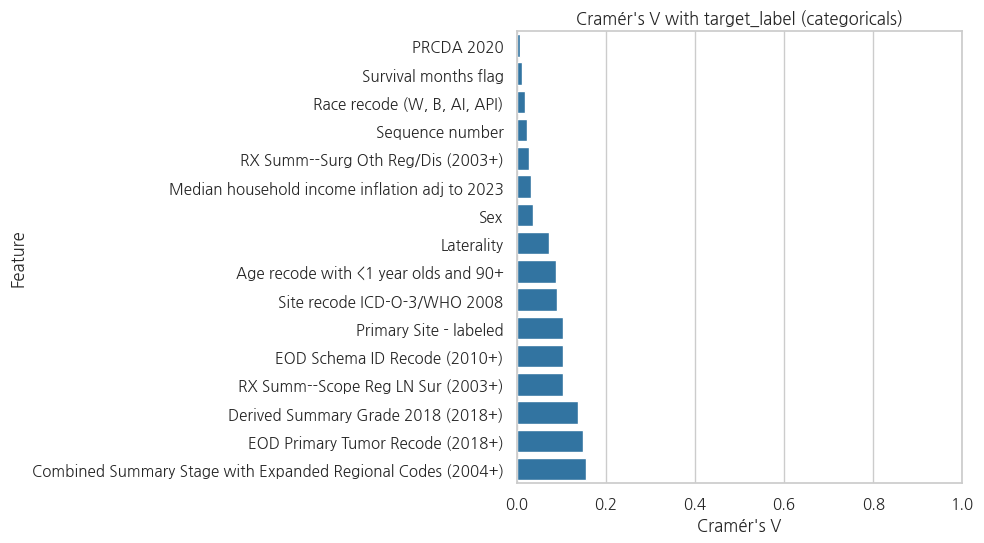

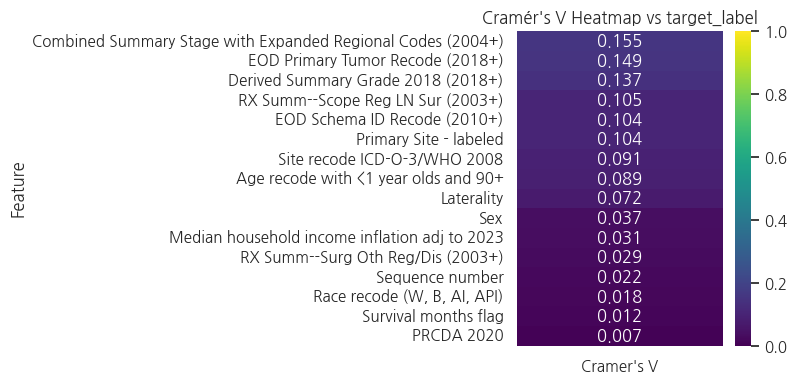

In [37]:
# 막대그래프 시각화 (상위 N개)
TOP_N = min(30, len(cv_df))
to_plot = cv_df.head(TOP_N).iloc[::-1]  # 큰 값이 위에 오도록 역순
plt.figure(figsize=(10, max(4, 0.35 * TOP_N)))
sns.barplot(data=to_plot, x="Cramer's V", y='feature', color='tab:blue')
plt.title("Cramér's V with target_label (categoricals)")
plt.xlim(0, 1)
plt.xlabel("Cramér's V")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 히트맵 (1열)
if not cv_df.empty:
    heat = cv_df.set_index('feature')[["Cramer's V"]]
    plt.figure(figsize=(8, max(3, 0.25 * len(heat))))
    sns.heatmap(heat, annot=True, fmt='.3f', cmap='viridis', vmin=0, vmax=1, cbar=True)
    plt.title("Cramér's V Heatmap vs target_label")
    plt.xlabel("")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


## Encoded Features vs Target (Heatmap)

`encoded_df`의 수치화된 피처들에 대해 `target_label`과의 스피어만 상관(Spearman r)을 계산해 히트맵으로 시각화합니다.


In [38]:
# Spearman 상관으로 target_label과의 연관성 계산
num_cols = [c for c in encoded_df.columns if encoded_df[c].dtype.kind in ('i','u','f')]
exclude_num = {'Patient ID'}  # 식별자 제거
num_cols = [c for c in num_cols if c not in exclude_num]

if 'target_label' not in encoded_df.columns:
    raise KeyError('target_label not found in encoded_df')

corr_with_target = encoded_df[num_cols].corrwith(encoded_df['target_label'], method='spearman').sort_values(ascending=False)
corr_df = corr_with_target.to_frame(name='Spearman r').rename_axis('feature').reset_index()
display(corr_df)


,feature,Spearman r
0,target_label,1.000000
1,Year of diagnosis,0.192180
2,Age recode with <1 year olds and 90+,0.168174
3,Primary Site,0.126557
4,Primary Site - labeled,0.126557
5,EOD Schema ID Recode (2010+),0.119967
6,Sex,0.035899
7,RX Summ--Surg Oth Reg/Dis (2003+),0.023573
8,Laterality,0.020985
9,"Race recode (W, B, AI, API)",0.005685


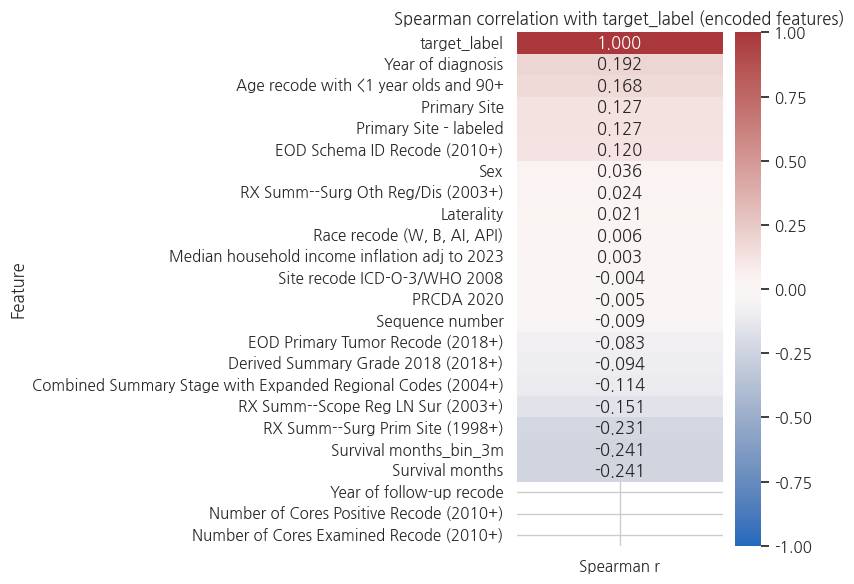

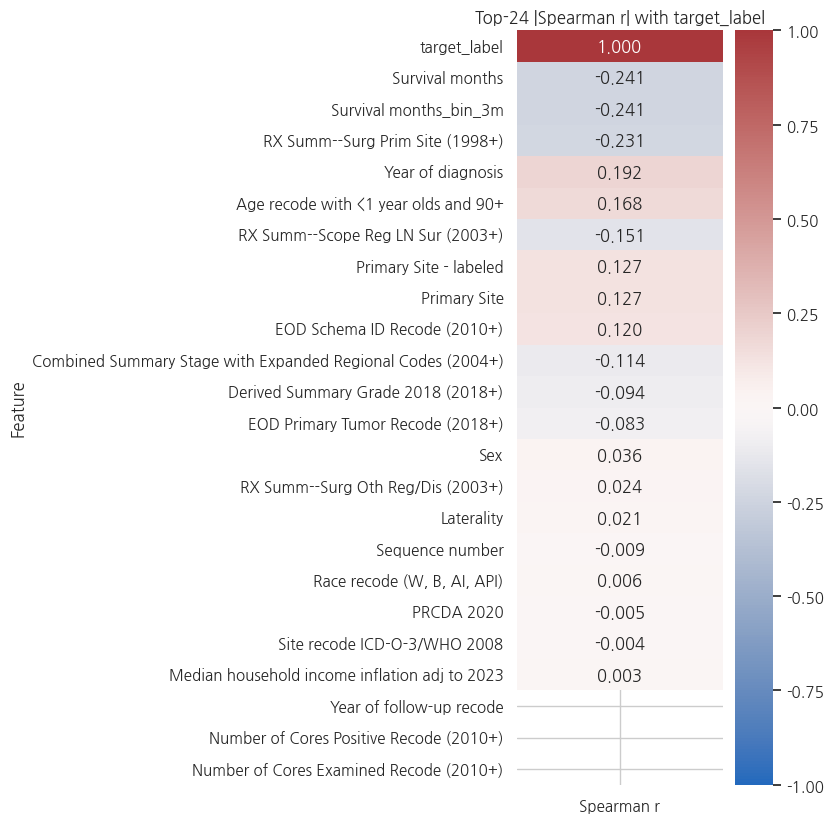

In [39]:
# 1열 히트맵 (전체 피처)
if not corr_with_target.empty:
    heat = corr_with_target.to_frame(name='Spearman r')
    plt.figure(figsize=(8, max(3, 0.25 * len(heat))))
    sns.heatmap(heat, annot=True, fmt='.3f', cmap='vlag', vmin=-1, vmax=1, cbar=True)
    plt.title('Spearman correlation with target_label (encoded features)')
    plt.xlabel('')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# 상위 |r| 기준 TOP_N 피처만 별도 히트맵
TOP_N = min(25, len(corr_with_target))
top_abs = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).head(TOP_N).index)
heat2 = top_abs.to_frame(name='Spearman r')
plt.figure(figsize=(8, max(3, 0.35 * len(heat2))))
sns.heatmap(heat2, annot=True, fmt='.3f', cmap='vlag', vmin=-1, vmax=1, cbar=True)
plt.title(f'Top-{TOP_N} |Spearman r| with target_label')
plt.xlabel('')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Survival months vs Death probability

x축은 `Survival months`, y축은 `target_label != -1` (사망) 확률로 시계열 형태 변화를 확인합니다. 3개월 구간(`Survival months_bin_3m`) 기준도 함께 시각화합니다.


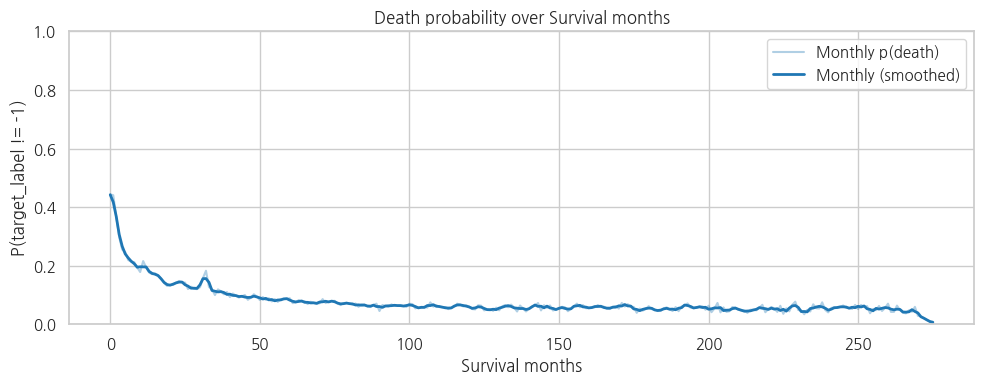

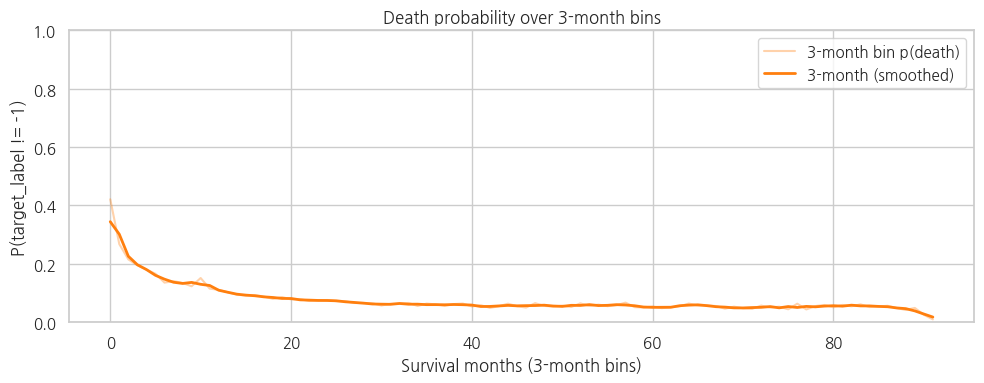

In [40]:
# 사망 확률(= target_label != -1) 시계열 형태로 시각화
cols_needed = ['Survival months', 'Survival months_bin_3m', 'target_label']
missing = [c for c in cols_needed if c not in encoded_df.columns]
if missing:
    raise KeyError(f'Missing columns in encoded_df: {missing}')

tmp = encoded_df[cols_needed].copy()
tmp = tmp.dropna(subset=['Survival months'])
tmp['is_death'] = (tmp['target_label'] != -1).astype(int)

# 월별 사망 확률
grp_m = tmp.groupby('Survival months').agg(p_death=('is_death','mean'), n=('is_death','size')).reset_index().sort_values('Survival months')
# 소수 구간의 노이즈를 줄이기 위해 최소 샘플 수 필터
N_MIN = 50
grp_mf = grp_m[grp_m['n'] >= N_MIN].copy()
grp_mf['p_smooth'] = grp_mf['p_death'].rolling(window=3, center=True, min_periods=1).mean()

plt.figure(figsize=(10, 4))
plt.plot(grp_mf['Survival months'], grp_mf['p_death'], color='tab:blue', alpha=0.35, label='Monthly p(death)')
plt.plot(grp_mf['Survival months'], grp_mf['p_smooth'], color='tab:blue', linewidth=2.0, label='Monthly (smoothed)')
plt.ylim(0, 1)
plt.title('Death probability over Survival months')
plt.xlabel('Survival months')
plt.ylabel('P(target_label != -1)')
plt.legend()
plt.tight_layout()
plt.show()

# 3개월 구간별 사망 확률
grp_b = tmp.groupby('Survival months_bin_3m').agg(p_death=('is_death','mean'), n=('is_death','size')).reset_index().sort_values('Survival months_bin_3m')
grp_bf = grp_b[grp_b['n'] >= N_MIN].copy()
grp_bf['p_smooth'] = grp_bf['p_death'].rolling(window=3, center=True, min_periods=1).mean()

plt.figure(figsize=(10, 4))
plt.plot(grp_bf['Survival months_bin_3m'], grp_bf['p_death'], color='tab:orange', alpha=0.35, label='3-month bin p(death)')
plt.plot(grp_bf['Survival months_bin_3m'], grp_bf['p_smooth'], color='tab:orange', linewidth=2.0, label='3-month (smoothed)')
plt.ylim(0, 1)
plt.title('Death probability over 3-month bins')
plt.xlabel('Survival months (3-month bins)')
plt.ylabel('P(target_label != -1)')
plt.legend()
plt.tight_layout()
plt.show()


## Death Probability by Primary Site

Primary Site 별로 사망 확률(`target_label != -1`)을 계산해 막대그래프로 비교합니다.


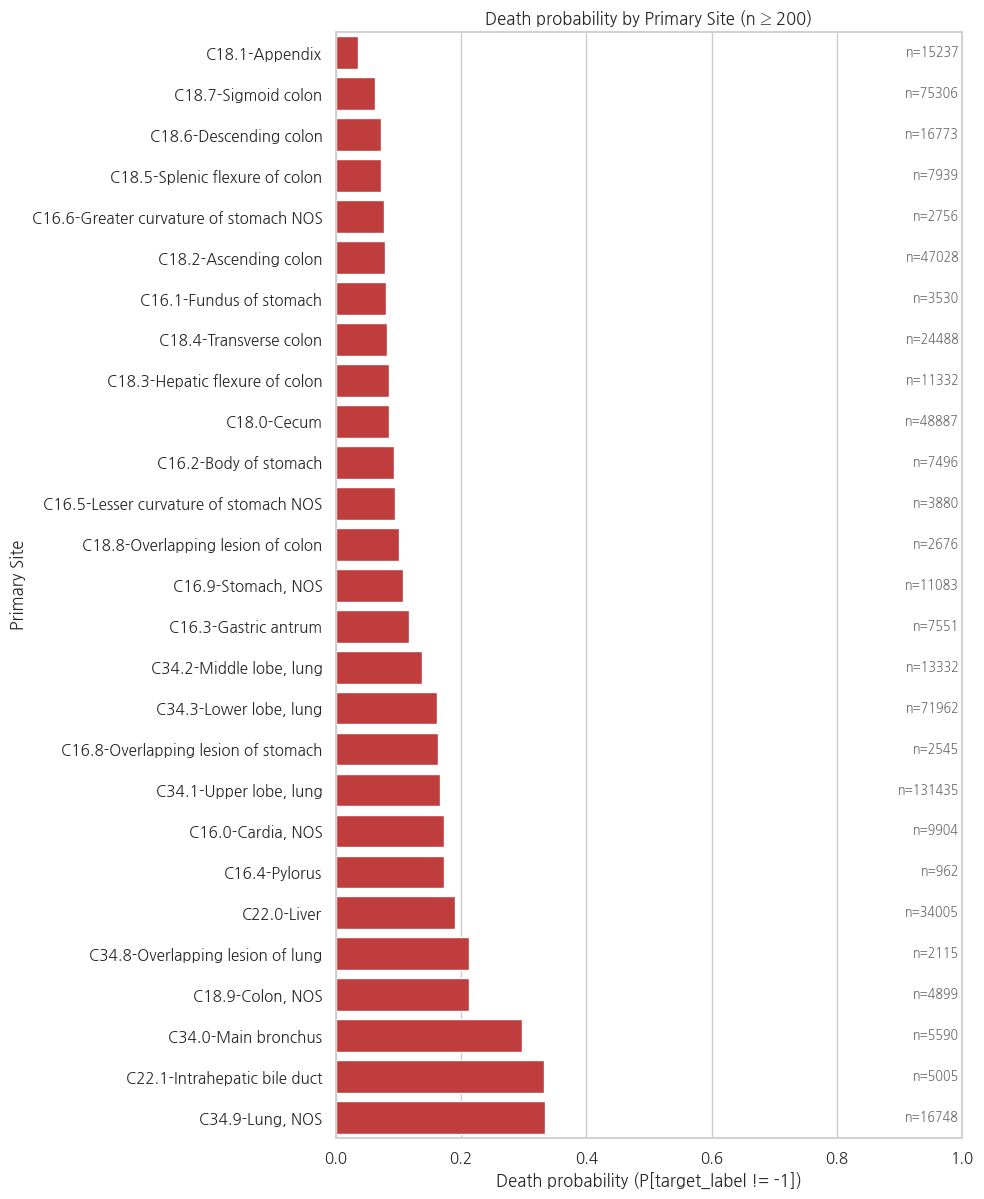

In [41]:
# Primary Site 별 사망 확률 막대그래프
SITE_COL = 'Primary Site - labeled' if 'Primary Site - labeled' in df_cat.columns else 'Primary Site'
cols_needed = [SITE_COL, 'target_label']
missing = [c for c in cols_needed if c not in df_cat.columns]
if missing:
    raise KeyError(f'Missing columns in merged df: {missing}')

tmp = df_cat[cols_needed].dropna().copy()
tmp['is_death'] = (tmp['target_label'] != -1).astype(int)

grp = (tmp.groupby(SITE_COL)
          .agg(p_death=('is_death','mean'), n=('is_death','size'))
          .reset_index())

# 표본 수가 너무 적은 카테고리 제거
N_MIN = 200
grp_f = grp[grp['n'] >= N_MIN].copy()
# death probability가 큰 순서대로 정렬
grp_f = grp_f.sort_values('p_death', ascending=False).reset_index(drop=True)

TOP_N = min(30, len(grp_f))
plot_df = grp_f.head(TOP_N)
# seaborn order로 카테고리 순서를 고정 (큰 값이 그래프 상단)
order = plot_df.iloc[::-1][SITE_COL].tolist()

plt.figure(figsize=(10, max(4, 0.45 * TOP_N)))
ax = sns.barplot(data=plot_df, x='p_death', y=SITE_COL, color='tab:red', order=order)
plt.xlim(0, 1)
plt.xlabel('Death probability (P[target_label != -1])')
plt.ylabel('Primary Site')
plt.title('Death probability by Primary Site (n ≥ %d)' % N_MIN)
# 표본 수 주석: 우측 끝 정렬
pos_map = {cat: idx for idx, cat in enumerate(order)}
for _, r in plot_df.iterrows():
    y = pos_map[r[SITE_COL]]
    ax.text(0.995, y, f"n={int(r['n'])}", transform=ax.get_yaxis_transform(),
            va='center', ha='right', fontsize=9, color='dimgray', clip_on=False)
plt.tight_layout()
plt.show()


## Append Encoded COD/Vital/Survival Flag

시각화용으로 원본(raw) 데이터의 COD, Vital status, Survival months flag를 라벨 인코딩해 최종 인코딩 데이터셋에 병합합니다.


In [42]:
# 분석용 추가 컬럼(COD/Vital/Survival flag) 인코딩 및 병합
extra_cols = [
    'COD to site recode',
    'Vital status recode (study cutoff used)',
    'Survival months flag',
]
missing = [c for c in extra_cols if c not in risk_df.columns]
if missing:
    raise KeyError(f"Missing expected columns in raw risk_df: {missing}")

extra_raw = risk_df[['Patient ID'] + extra_cols].copy()

# 'Patient ID'는 제외하고 명목형 라벨 인코딩 수행 (결측/미등록=-1)
extra_encoded, extra_maps = DataPreprocessing.encode_nominal_columns(
    extra_raw,
    exclude_columns=['Patient ID'],
)
# 원래 컬럼과 충돌하지 않도록 '__enc' 접미사 추가
to_rename = {c: f"{c}__enc" for c in extra_encoded.columns if c != 'Patient ID'}
extra_encoded = extra_encoded.rename(columns=to_rename)

# 최종 인코딩 데이터셋에 좌측 조인으로 병합 후 미리보기
encoded_cod_df = encoded_df.merge(extra_encoded, on='Patient ID', how='left')
# 'Unnamed' 또는 빈 이름의 불필요 컬럼이 있으면 제거 (CSV에서 인덱스가 저장된 경우 등)
drop_cands = [c for c in encoded_cod_df.columns if (str(c).startswith('Unnamed') or str(c).strip() == '' or c is None)]
if drop_cands:
    encoded_cod_df = encoded_cod_df.drop(columns=drop_cands)
# 인덱스가 컬럼화되지 않도록 재설정 (저장 시 불필요한 번호 컬럼 방지)
encoded_cod_df = encoded_cod_df.reset_index(drop=True)
# 결과 미리보기
encoded_cod_df.head()


,Patient ID,Age recode with <1 year olds and 90+,Sex,Year of diagnosis,Year of follow-up recode,"Race recode (W, B, AI, API)",Site recode ICD-O-3/WHO 2008,Primary Site,Primary Site - labeled,Derived Summary Grade 2018 (2018+),...,Number of Cores Positive Recode (2010+),Number of Cores Examined Recode (2010+),EOD Primary Tumor Recode (2018+),PRCDA 2020,Survival months,target_label,Survival months_bin_3m,COD to site recode__enc,Vital status recode (study cutoff used)__enc,Survival months flag__enc
0,671,14,1,18,0,4,10,341,22,2,...,0,0,10,0,59,-1,19,0,0,0
1,812,14,0,22,0,4,18,163,3,12,...,0,0,3,0,7,-1,2,0,0,0
2,878,13,1,4,0,4,0,181,10,8,...,0,0,22,0,218,-1,72,0,0,0
3,1018,15,0,11,0,4,1,182,11,8,...,0,0,22,0,134,-1,44,0,0,0
4,1269,9,0,7,0,4,16,187,16,8,...,0,0,22,0,187,-1,62,0,0,0


In [43]:
print(encoded_cod_df['COD to site recode__enc'].unique())
print(encoded_cod_df['Vital status recode (study cutoff used)__enc'].unique())
print(encoded_cod_df['Survival months flag__enc'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 50
 51 53 54 55 56 57 58 59 60 61 62 63 65 66 67 69 70 71 72 73 74 75 76 77
 78 79 80 82 83 85 86 87 88 89]
[0 1]
[0 1 3 2 4]


In [44]:
# 저장 시 인덱스 컬럼을 파일에 쓰지 않도록 설정
encoded_cod_df.to_csv('../data/EDA/encoded_dataset_COD.csv', index=False)


In [46]:
# Dump label→original mappings for encoded COD/Vital/Survival flag and update markdown
from pathlib import Path
cols = ['COD to site recode','Vital status recode (study cutoff used)','Survival months flag']
try:
    _maps = extra_maps
except NameError:
    extra_cols = cols
    extra_raw = risk_df[['Patient ID'] + extra_cols].copy()
    extra_encoded, _maps = DataPreprocessing.encode_nominal_columns(
        extra_raw,
        exclude_columns=['Patient ID'],
    )

def invert_map(m):
    return {v: k for k, v in m.items() if isinstance(v, int) and v >= 0}

lines = []
for col in cols:
    if col not in _maps:
        continue
    inv = invert_map(_maps[col])
    lines.append(f'[{col}]')
    for k in sorted(inv):
        lines.append(f'{k} -> {inv[k]}')
    lines.append('')
dump_path = Path('encoded_label_dump.txt')
dump_path.write_text('\n'.join(lines), encoding='utf-8')
print(f'Saved mapping dump to {dump_path.resolve()}')

# Update encoded_label.md between markers
md_path = Path('encoded_label.md')
if md_path.exists():
    text = md_path.read_text(encoding='utf-8')
else:
    text = ''
start = '<!-- BEGIN AUTO MAPPING -->'
end = '<!-- END AUTO MAPPING -->'
block = ['**정수→원본 매핑 (실행 결과)**', '',] + [
    x if not x or x.startswith('[') else f'- {x}' for x in lines
]
block_text = start + '\n' + '\n'.join(block) + '\n' + end
if start in text and end in text:
    pre = text.split(start)[0]
    post = text.split(end)[-1]
    new_text = pre + block_text + post
else:
    # Append at the end
    new_text = text + ('\n\n' if text else '') + block_text + '\n'
md_path.write_text(new_text, encoding='utf-8')
print(f'Updated {md_path.resolve()}')


Saved mapping dump to /home/maroco/SKN19_2ND_5TEAM/insight/encoded_label_dump.txt
Updated /home/maroco/SKN19_2ND_5TEAM/insight/encoded_label.md
